<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/MA_and_Momentum_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moving Average

Moving average is a series of averages points between many fixed subsets of a dataset. 

## Simple Moving Average
The unweighted mean of the previous k data-points.

\begin{aligned}
S M A_{k} &=\frac{p_{n-k+1}+p_{n-k+2} \cdots+p_{n}}{k} \\
&=\frac{1}{k} \sum_{i=n-k+1}^{n} p_{i}
\end{aligned}

## Cumulative Moving Average
The data arrive in an ordered datum stream, and the user would like to get the average of all of the data up until the current datum
\begin{aligned}
C M A_{n+1} &=\frac{x_{n+1}+n \cdot C M A_{n}}{n+1} \\
&=\frac{x_{n+1}+(n+1-1) \cdot C M A_{n}}{n+1} \\
&=\frac{(n+1) \cdot C M A_{n}+x_{n+1}-C M A_{n}}{n+1} \\
&=C M A_{n}+\frac{x_{n+1}-C M A_{n}}{n+1}
\end{aligned}

Where :
\begin{equation}
C M A_{n}=\frac{x_{1}+\cdots+x_{n}}{n}
\end{equation}

## Weighted Moving Average

The average that has multiplying factors to give different weights to data at different positions in the sample window. Mathematically, the weighted moving average is the convolution of the data with a fixed weighting function.

\begin{equation}
\mathrm{WMA}_{M}=\frac{n p_{M}+(n-1) p_{M-1}+\cdots+2 p_{((M-n)+2)}+p_{((M-n)+1)}}{n+(n-1)+\cdots+2+1}
\end{equation}

## Exponential Moving Average

The first-order infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. The graph at right shows an example of the weight decrease.

$$
\mathrm{EMA}_{\text {today }}=\frac{p_{1}+(1-\alpha) p_{2}+(1-\alpha)^{2} p_{3}+(1-\alpha)^{3} p_{4}+\cdots}{1+(1-\alpha)+(1-\alpha)^{2}+(1-\alpha)^{3}+\cdots}
$$
since $1 / \alpha=1+(1-\alpha)+(1-\alpha)^{2}+\cdots$.

# Momentum
Momentum investing is a system of buying stocks or other securities that have had high returns over the past three to twelve months, and selling those that have had poor returns over the same period.

In [ ]:
#backtrader
!pip install backtrader

     |████████████████████████████████| 410 kB 37.9 MB/s 


In [ ]:
import math
from time import time
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
from scipy.stats import linregress
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Vizualise the Stock Price Over Time

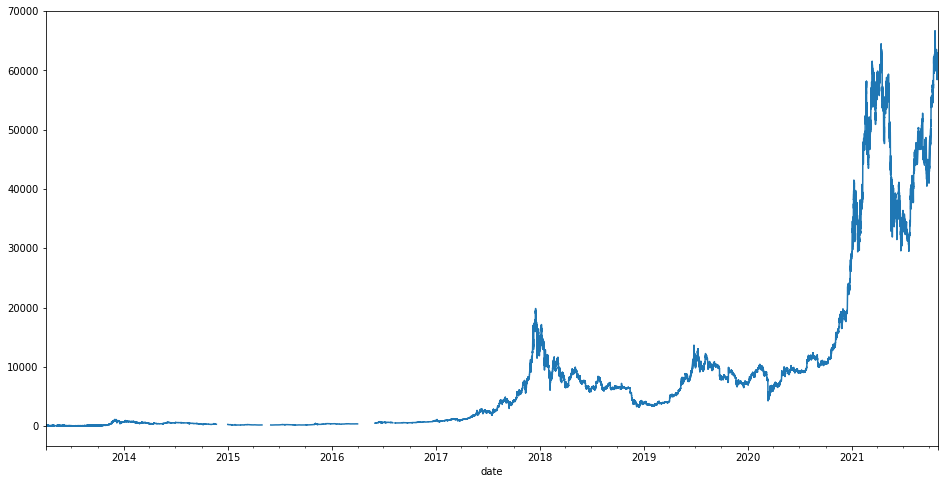

In [ ]:
#read data
df = pd.read_csv('/content/drive/MyDrive/Yoctobe Fintech/Datasets/btcusd30mn.csv', parse_dates=True)
df.head()
# #setting index as date because some statsmodels might not work
df.rename(columns={'datetime': 'date'}, inplace=True)
df.index = df['date']
df.index = pd.to_datetime(df.index)
#plot
df['close'].plot(figsize=(16,8))

In [ ]:
# resample df
ddf = df.resample("D").mean()
# using a range of 1 year of dates
mask = (ddf.index > '2018-01-01') & (ddf.index <= '2021-01-01')
ddf = ddf.loc[mask]

In [ ]:
## Initialize the short and long windows
short_window = 30
long_window = 90


# Initialize signals
signals = pd.DataFrame(index=ddf.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ddf['close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = ddf['close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
# Generate trading orders
signals['positions'] = signals['signal'].diff()

print(signals)

            signal    short_mavg     long_mavg  positions
date                                                     
2018-01-02     0.0  13847.884703  13847.884703        NaN
2018-01-03     0.0  14396.270443  14396.270443        0.0
2018-01-04     0.0  14524.607221  14524.607221        0.0
2018-01-05     0.0  14845.563387  14845.563387        0.0
2018-01-06     0.0  15214.488856  15214.488856        0.0
...            ...           ...           ...        ...
2020-12-28     1.0  20977.580282  16288.721677        0.0
2020-12-29     1.0  21266.347094  16465.387151        0.0
2020-12-30     1.0  21573.918825  16658.444277        0.0
2020-12-31     1.0  21892.186717  16861.612705        0.0
2021-01-01     1.0  22234.155293  17069.047768        0.0

[1096 rows x 4 columns]


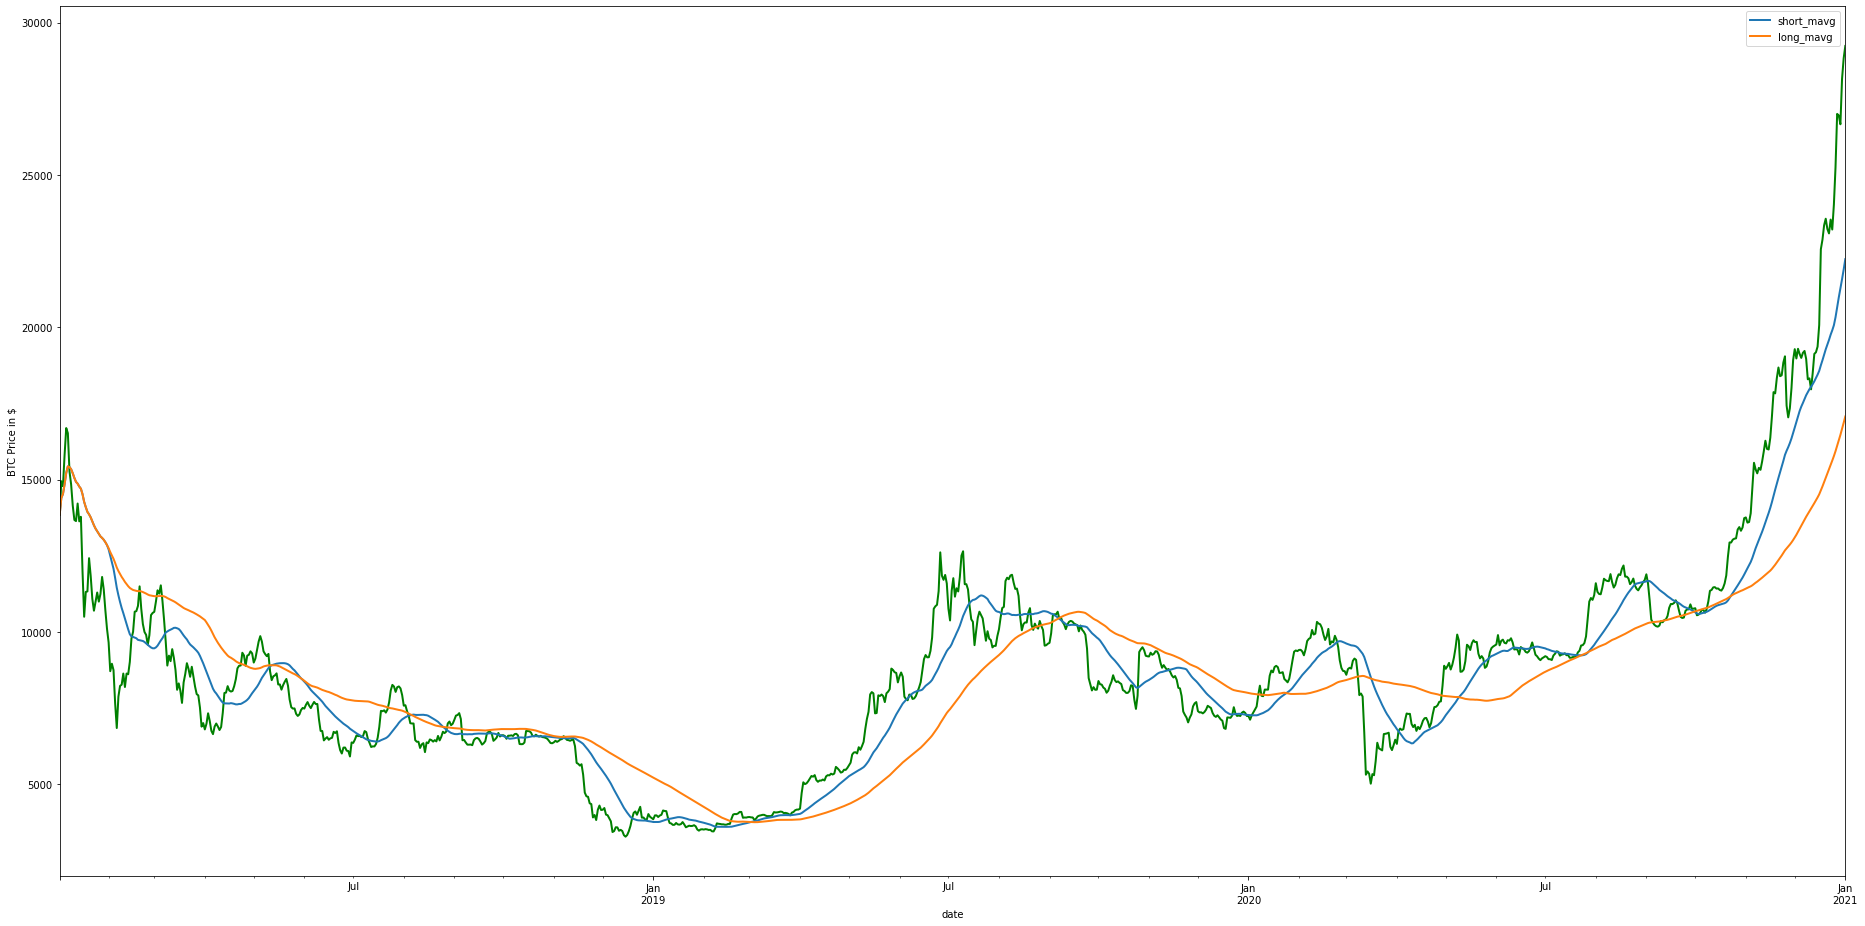

In [ ]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel='BTC Price in $')

## Plot the closing price
ddf['close'].plot(ax=ax1, color='g', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=15, color='b')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=15, color='k')
         
# Show the plot
plt.show()

In [ ]:
ddf['close'].head()

date
2018-01-02    13847.884703
2018-01-03    14944.656183
2018-01-04    14781.280775
2018-01-05    15808.431888
2018-01-06    16690.190732
Freq: D, Name: close, dtype: float64

# Backtest

                     BTC      holdings         cash     total   returns
date                                                                   
2018-01-02      0.000000      0.000000  1000.000000   1000.00       NaN
2018-01-03      0.000000      0.000000  1000.000000   1000.00  0.000000
2018-01-04      0.000000      0.000000  1000.000000   1000.00  0.000000
2018-01-05      0.000000      0.000000  1000.000000   1000.00  0.000000
2018-01-06      0.000000      0.000000  1000.000000   1000.00  0.000000
...                  ...           ...          ...       ...       ...
2020-12-18  22874.311531  22874.311531 -9062.873664  13811.44  0.023420
2020-12-19  23344.690193  23344.690193 -9062.873664  14281.82  0.034057
2020-12-20  23561.336009  23561.336009 -9062.873664  14498.46  0.015169
2020-12-21  23224.859059  23224.859059 -9062.873664  14161.99 -0.023207
2020-12-22  23078.960415  23078.960415 -9062.873664  14016.09 -0.010302

[1086 rows x 5 columns]


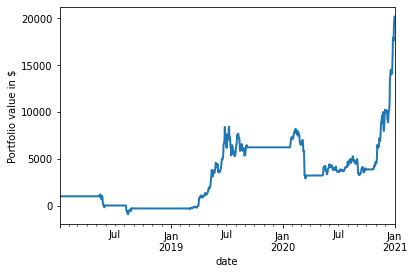

In [ ]:
# Set the initial capital
initial_capital= float(1000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy n share
shares = 1
positions['BTC'] = shares*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ddf['close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ddf['close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(ddf['close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = round(portfolio['cash'] + portfolio['holdings'], 2)

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio.total.plot(ax=ax1, lw=2.)


# Print the first lines of `portfolio`
print(portfolio.head(-10))

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()